In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)

In [ ]:
stocks_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/investHub/data/clean/clean_dataset.csv", delimiter=';')

stocks_df.drop(['Ticker'], axis=1, inplace=True)
stocks_df.describe(include='all')

,Ano,LPA,P_L,VPA,P_VP,P_EBIT,P_EBITDA,P_Ativos,Ebitda,Marg_Ebitda,PSR,ROE,ROA,ROIC,EV_EBIT,EV_EBITDA,Div_Yield,Div_Payout,Beta,Valorizacao,Negocios_dia,Volume_diario
count,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000,3187.00000,3187.000000,3187.000000,3187.000000,3187.000000,3187.000000
mean,2013.769376,6.270857,11.544634,67.911500,2.123392,9.223687,7.614995,3.397142,2094.563226,0.161774,2.675190,0.103271,0.030788,0.080910,33.157895,24.197364,0.03246,0.295680,0.667954,0.228544,3617.878883,35.145905
std,5.460107,319.524882,133.108552,2940.514647,30.991602,88.216473,91.793554,136.628798,9416.293552,0.516595,12.591619,0.690634,0.183385,0.278758,227.670487,195.754978,0.05800,0.781007,1.558678,0.681226,6832.710589,114.810186
min,1998.000000,-666.670000,-3856.920000,-695.020000,-1714.190000,-3856.920000,-3675.010000,0.000000,-26555.000000,-7.920000,-0.820000,-9.370000,-2.540000,-4.720000,-4262.930000,-1756.270000,0.00000,-9.000000,-34.890000,-0.960000,0.000000,0.000000
25%,2010.000000,0.160000,4.240000,4.220000,0.820000,3.690000,1.565000,0.340000,26.500000,0.030000,0.580000,0.040000,0.010000,0.050000,8.115000,3.945000,0.00000,0.000000,0.350000,-0.160000,53.000000,1.000000
50%,2015.000000,0.880000,9.880000,8.880000,1.520000,7.390000,5.110000,0.640000,308.000000,0.150000,1.210000,0.120000,0.050000,0.090000,15.880000,10.440000,0.01730,0.180000,0.600000,0.100000,612.000000,5.000000
75%,2018.000000,2.255000,20.005000,18.390000,2.850000,13.775000,9.715000,1.170000,1369.500000,0.270000,2.435000,0.210000,0.080000,0.150000,34.100000,19.650000,0.04210,0.440000,0.900000,0.440000,4135.500000,27.000000
max,2021.000000,18000.000000,928.230000,166000.000000,133.390000,1376.110000,2773.090000,7713.850000,187142.000000,6.090000,489.610000,7.670000,3.160000,4.000000,4836.200000,8073.900000,1.09640,9.380000,42.370000,8.020000,59190.000000,2913.000000


In [ ]:
y, X = stocks_df.Valorizacao , stocks_df.drop('Valorizacao', axis=1)

print("X", X.shape)
print("y", y.shape)

X (3187, 21)
y (3187,)


In [ ]:
seed = 1

# separando treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, random_state=seed, test_size=0.25) #, stratify=y)
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

# separando treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, random_state=seed,
                                                  test_size=0.33) #, stratify=y_training)

print("Train set X", X_train.shape)
print("Train set y", y_train.shape)
print("Validation set X", X_val.shape)
print("Validation set y", y_val.shape)

Test set X (797, 21)
Test set y (797,)
Train set X (1601, 21)
Train set y (1601,)
Validation set X (789, 21)
Validation set y (789,)


In [ ]:
# Linear Regression com validação cruzada

# criando o objeto do modelo com LinearRegression
lr_model_cv = LinearRegression()

# treinando o modelo
lr_model_cv.fit(X_training, y_training)

# pegando os resultados da validação cruzada (cv_results)
cv_results = cross_val_score(lr_model_cv,X_training,y_training,cv=3,scoring='r2')
    
print('CV Mean: ', np.mean(scores))
print('STD: ', np.std(scores))



CV Mean:  -1108.212169119224
STD:  1544.7148002421404


In [ ]:
# Random Forest com validação cruzada e Grid Search

# definindo os valores possíveis dos parâmetros a serem testados
params = {'n_estimators': [50, 100, 150],
          'max_depth': [5, 10, 50],
          'max_features': [9, 13, 17],
          'min_samples_split': [2 ,5, 20],}

# criando o objeto do modelo com RandomForestRegressor
rf_model_cv_gs = RandomForestRegressor(random_state=seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_root_mean_squared_error')

# treinando o modelo com o grid search
grid_search.fit(X_training, y_training)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)


 Best hyperparameters:
{'max_depth': 50, 'max_features': 17, 'min_samples_split': 2, 'n_estimators': 150}


Average accuracy on train set: -0.218 +/- 0.005
Average accuracy on validation set: -0.583 +/- 0.066


<BarContainer object of 2 artists>

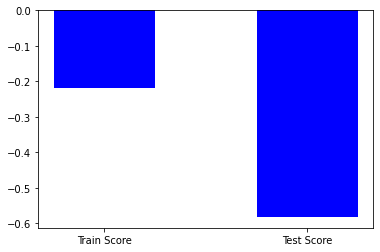

In [ ]:
# imprimindo o score médio nas bases de treino
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0])) 
# imprimindo o score médio nas bases de validação
print("Average accuracy on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) 

# configurando o modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.set_params(n_estimators = cv_best_params['n_estimators'],
                        max_depth = cv_best_params['max_depth'],
                        max_features = cv_best_params['max_features'],
                        min_samples_split = cv_best_params['min_samples_split'])

# treinando um modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.fit(X_training, y_training)
best_model_params = rf_model_cv_gs.get_params()

y = [cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0], 
     cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0]]
x = ["Train Score", "Test Score"]
width = 1/2
plt.bar(x, y, width, color="blue")  

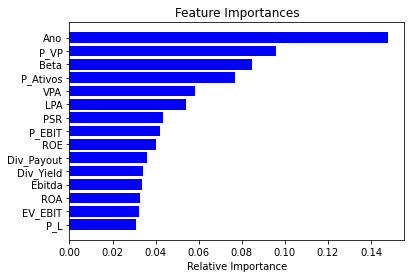

In [ ]:
# desenhando o gráfico de impoartância de variáveis
features = X_training.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

feature_importances_df = pd.DataFrame({'features': features,
                                       'importances': importances})

plt.title('Feature Importances')
plt.barh(range(len(importances[indices][-15:])), importances[indices][-15:], color='b', align='center')
plt.yticks(range(len(importances[indices][-15:])), [features[i] for i in indices[-15:]])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
y_test_pred_rf = rf_model_cv_gs.predict(X_test)
rmse_test_rf = math.sqrt(mean_squared_error(y_test, y_test_pred_rf))
print(rmse_test_rf)
print("Explained variance score: {:.3f}".format(explained_variance_score(y_test, y_test_pred_rf)))
print("Mean absolute error (MAE): {:.3f}".format(mean_absolute_error(y_test, y_test_pred_rf)))
print("Mean squared error (MSE): {:.3f}".format(mean_squared_error(y_test, y_test_pred_rf)))
print("Mean squared log error (MSLE): {:.3f}".format(mean_squared_log_error([x if x >= 0 else 0 for x in y_test], [x if x >= 0 else 0 for x in y_test_pred_rf]))) # tratando valores negativos que podem ser previstos pela rede neural
print("R² Score: {:.3f}".format(r2_score(y_test, y_test_pred_rf)))

0.5064567034406737
Explained variance score: 0.388
Mean absolute error (MAE): 0.351
Mean squared error (MSE): 0.256
Mean squared log error (MSLE): 0.066
R² Score: 0.387


In [ ]:
# Light GBM com validação cruzada e Grid Search

# definindo os valores possíveis dos parâmetros a serem testados
params = {'max_depth': [10, 50, 100],
          'learning_rate': [0.01, 0.1, 0.5],
          'n_estimators': [100, 200, 500],
          'min_data_in_leaf': [20, 50],
          'min_gain_to_split': [0., 1, 5]}

# criando o objeto do modelo com XGBClassifier
lgb_model_cv_gs = lgb.LGBMRegressor(random_state = seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(lgb_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_root_mean_squared_error')

# treinando o modelo com o grid search
grid_search.fit(X_training, y_training)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)


 Best hyperparameters:
{'learning_rate': 0.01, 'max_depth': 50, 'min_data_in_leaf': 20, 'min_gain_to_split': 0.0, 'n_estimators': 500}


Average accuracy on train set: -0.354 +/- 0.008
Average accuracy on validation set: -0.569 +/- 0.069


<BarContainer object of 2 artists>

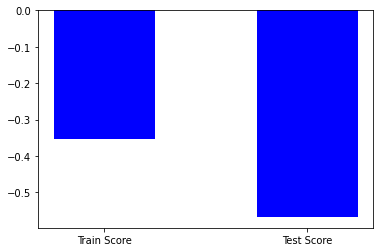

In [ ]:
# imprimindo o score médio nas bases de treino
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))

# imprimindo o score médio nas bases de validação
print("Average accuracy on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0]))

# configurando o modelo com a melhor combinação de hiperparâmetros
lgb_model_cv_gs.set_params(learning_rate = cv_best_params['learning_rate'],
                           n_estimators = cv_best_params['n_estimators'],
                           max_depth = cv_best_params['max_depth'],
                           min_data_in_leaf = cv_best_params['min_data_in_leaf'],
                           min_gain_to_split = cv_best_params['min_gain_to_split'])

# treinando um modelo com a melhor combinação de hiperparâmetros
lgb_model_cv_gs.fit(X_training, y_training)
best_model_params = lgb_model_cv_gs.get_params()

y = [cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0], 
     cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0]]
x = ["Train Score", "Test Score"]
width = 1/2
plt.bar(x, y, width, color="blue")  

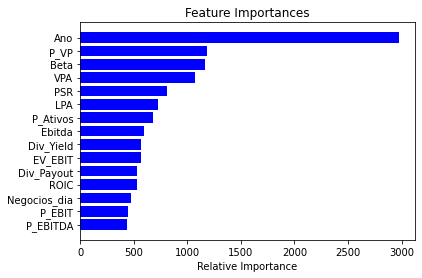

In [ ]:
# desenhando o gráfico de impoartância de variáveis
features = X_training.columns
importances = lgb_model_cv_gs.feature_importances_
indices = np.argsort(importances)

feature_importances_df = pd.DataFrame({'features': features,
                                       'importances': importances})

plt.title('Feature Importances')
plt.barh(range(len(importances[indices][-15:])), importances[indices][-15:], color='b', align='center')
plt.yticks(range(len(importances[indices][-15:])), [features[i] for i in indices[-15:]])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
y_test_pred_lgb = lgb_model_cv_gs.predict(X_test)
rmse_test_lgb = math.sqrt(mean_squared_error(y_test, y_test_pred_lgb))
print(rmse_test_lgb)
print("Explained variance score: {:.3f}".format(explained_variance_score(y_test, y_test_pred_lgb)))
print("Mean absolute error (MAE): {:.3f}".format(mean_absolute_error(y_test, y_test_pred_lgb)))
print("Mean squared error (MSE): {:.3f}".format(mean_squared_error(y_test, y_test_pred_lgb)))
print("Mean squared log error (MSLE): {:.3f}".format(mean_squared_log_error([x if x >= 0 else 0 for x in y_test], [x if x >= 0 else 0 for x in y_test_pred_lgb]))) # tratando valores negativos que podem ser previstos pela rede neural
print("R² Score: {:.3f}".format(r2_score(y_test, y_test_pred_lgb)))

0.4871388823962645
Explained variance score: 0.433
Mean absolute error (MAE): 0.333
Mean squared error (MSE): 0.237
Mean squared log error (MSLE): 0.061
R² Score: 0.433


In [ ]:
# Normalizando as variáveis com um scaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_val_scaled = sc.transform(X_val)

Score on training set: 0.215
Score on validation set: 0.081
Explained variance score: 0.084
Mean absolute error (MAE): 0.440
Mean squared error (MSE): 0.476
Mean squared log error (MSLE): 0.100
R² Score: 0.081


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


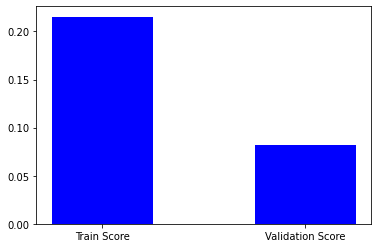

In [ ]:
# criando o objeto do modelo com MLPRegressor
neural_network_model = MLPRegressor(activation='tanh', 
                                    solver = 'lbfgs',
                                    hidden_layer_sizes=(4),
                                    early_stopping = True)

# treinando o modelo com os dados de treino
neural_network_model.fit(X_train_scaled, y_train)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val_scaled)

# calculando e imprimindo algumas métricas
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train_scaled, y_train)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val_scaled, y_val)))
y = [neural_network_model.score(X_train_scaled, y_train), 
     neural_network_model.score(X_val_scaled, y_val)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
print("Explained variance score: {:.3f}".format(explained_variance_score(y_val, y_pred)))
print("Mean absolute error (MAE): {:.3f}".format(mean_absolute_error(y_val, y_pred)))
print("Mean squared error (MSE): {:.3f}".format(mean_squared_error(y_val, y_pred)))
print("Mean squared log error (MSLE): {:.3f}".format(mean_squared_log_error([x if x >= 0 else 0 for x in y_val], [x if x >= 0 else 0 for x in y_pred]))) # tratando valores negativos que podem ser previstos pela rede neural
print("R² Score: {:.3f}".format(r2_score(y_val, y_pred)))

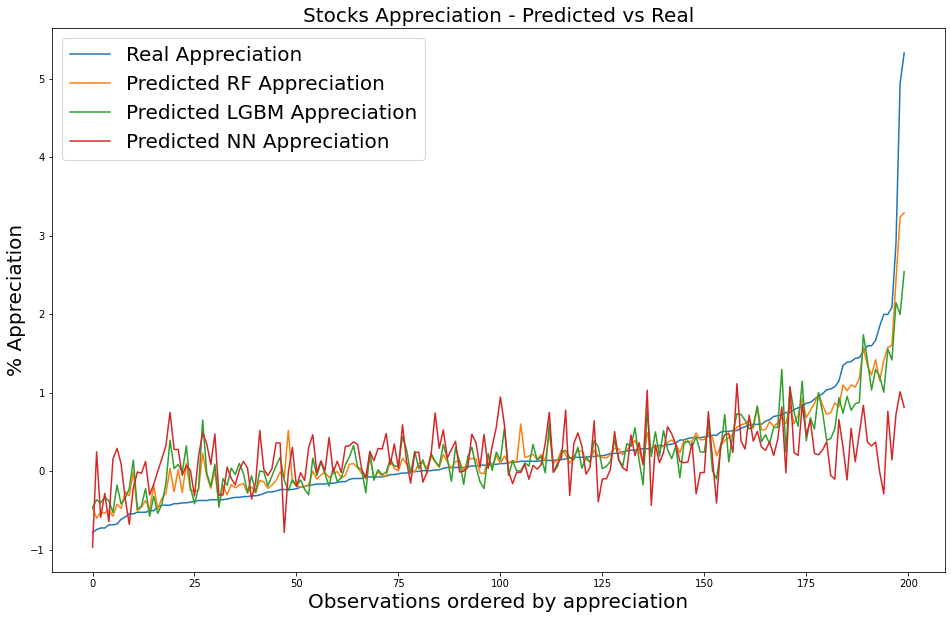

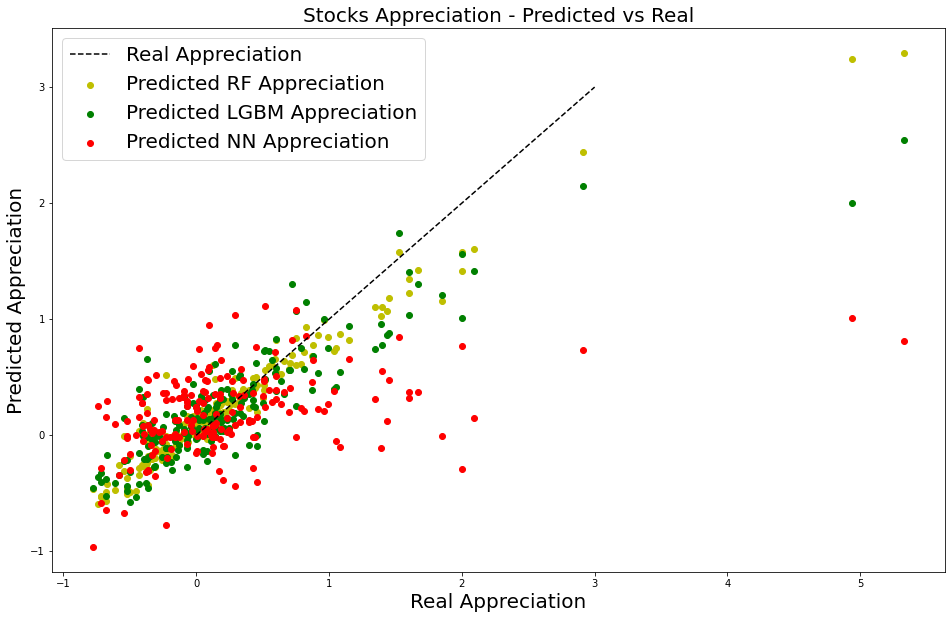

In [ ]:
# Desenhando o gráfico de valores previstos por valores reais para ambos os modelos

plt.figure(figsize=(16,10))
plt.title('Stocks Appreciation - Predicted vs Real',fontsize=20)
df = pd.DataFrame({'real':y_val,'Random Forest':rf_model_cv_gs.predict(X_val),
                   'LGBM':lgb_model_cv_gs.predict(X_val),
                   'NN':neural_network_model.predict(X_val_scaled)})
df = df.sample(200)
df.sort_values(by=['real'],ascending=True,inplace=True)
df = df.reset_index(drop=True)
plt.plot(df)
plt.legend(['Real Appreciation','Predicted RF Appreciation','Predicted LGBM Appreciation','Predicted NN Appreciation'],fontsize=20)
plt.ylabel('% Appreciation',fontsize=20)
plt.xlabel('Observations ordered by appreciation',fontsize=20)
plt.show()

plt.figure(figsize=(16,10))
plt.title('Stocks Appreciation - Predicted vs Real',fontsize=20)
plt.scatter(x=df['real'],y=df['Random Forest'],c='y')
plt.scatter(x=df['real'],y=df['LGBM'],c='g')
plt.scatter(x=df['real'],y=df['NN'],c='r')
plt.plot([0,3],[0,3],'k--')
# plt.axis([0,1750000,0,1750000])
plt.legend(['Real Appreciation','Predicted RF Appreciation','Predicted LGBM Appreciation','Predicted NN Appreciation'],fontsize=20)
plt.xlabel('Real Appreciation',fontsize=20)
plt.ylabel('Predicted Appreciation',fontsize=20)
plt.show()